#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [16]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install salesforce-lavis

In [1]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess
import os
os.environ['TRANSFORMERS_OFFLINE']='1'

/home/lijun07/miniconda3/envs/LAVIS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load an example image

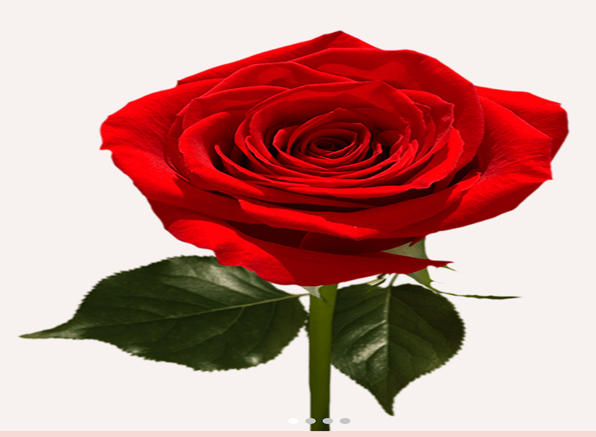

In [2]:
raw_image = Image.open("../docs/_static/rose.png").convert("RGB")
display(raw_image.resize((596, 437)))

In [3]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

#### Load pretrained/finetuned BLIP2 captioning model

In [4]:
# we associate a model with its preprocessors to make it easier for inference.
import os
#os.environ['TORCH_HOME']='/data/pretrained_checkpoint'
os.environ['TRANSFORMERS_OFFLINE']='1'
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_beit3_t5", model_type="pretrain_flant5b", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

load from /data/BLIP2/Pretrain_stage2/beit3+t5base/20230328203/checkpoint_19.pth


dict_keys(['train', 'eval'])

#### prepare the image as model input using the associated processors

In [5]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

#### generate caption using beam search

In [6]:
model.generate({"image": image})

['              ']

#### generate multiple captions using nucleus sampling

In [13]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

['i.e., i.e., i.e., i.e., i.e.,',
 'i.e., i.e., i.e., i.e., i.e.,',
 "i.e., if i were you, i'd be the one to put a stop to the tv"]

#### instructed zero-shot vision-to-language generation

In [9]:
model.generate({"image": image, "prompt": "Question: which color is this rose? Answer:"})

['white']

In [10]:
model.generate({
    "image": image,
    "prompt": "Question: which flower is this photo?  Answer: lily of valley. Question: why?"})

['lily of valley is a flower']

In [17]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [18]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['merlion is a slang term for a merry-go-round']